# Atlas de Oportunidades (FFG + Cotec)
## Exploración con pandas y exportación de datos para un dashboard

En este notebook:

1. Cargamos los datos descargados de la web del Atlas.
2. Exploramos la estructura de cada dataset (columnas, tipos, nulos).
3. Creamos tablas agregadas y limpias listas para dashboards.
4. Exportamos CSV:
   - Tablas "curadas" (para backend o análisis).
   - Datos exactos de los gráficos (para Svelte/D3).

**Antes de ejecutar:**
- Copia todos los CSV (`tabla_*.csv`, `conversor_*.csv`) a una carpeta (o déjalos en el directorio del notebook).
- Ajusta la variable `BASE_PATH` si los pones en otra carpeta.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set()

# Carpeta para CSV de datos de gráficos
EXPORT_CHARTS_PATH = "data/atlas_charts"
os.makedirs(EXPORT_CHARTS_PATH, exist_ok=True)

def export_chart_df(df: pd.DataFrame, name: str, index: bool = False):
    """Guarda el DataFrame usado en un gráfico como CSV.
    name: nombre base del fichero (sin .csv)
    index: si quieres guardar el índice como columna.
    """
    file_path = os.path.join(EXPORT_CHARTS_PATH, f"{name}.csv")
    df.to_csv(file_path, index=index)
    print(f"✅ Guardado CSV para gráfico: {file_path}")

## 1. Cargar los datos
Aquí usamos **tus nombres reales de archivo**.

- `tabla_nacional.csv` → datos nacionales (curva general).
- `tabla_ccaa.csv` → datos por CCAA.
- `tabla_prov.csv` → datos por provincia.
- `tabla_mun_grandes.csv`, `tabla_mun_fitted.csv` → datos municipales.
- `tabla_cp_fitted.csv` → datos por código postal.
- `tabla_quintiles_*.csv` → distribuciones por quintiles.
- `conversor_percentil_euro*.csv` → conversores centil ↔ euros.

Si los CSV están **en el mismo directorio que el notebook**, puedes dejar `BASE_PATH = "."`.

In [9]:
# Ruta base donde están los CSV ("." = misma carpeta del notebook)
BASE_PATH = r"datatset_atlas_oportunidad"  # cámbialo si los tienes en otra carpeta

# Archivos según tu listado
file_tabla_nacional          = f"{BASE_PATH}/tabla_nacional.csv"
file_tabla_ccaa              = f"{BASE_PATH}/tabla_ccaa.csv"
file_tabla_prov              = f"{BASE_PATH}/tabla_prov.csv"
file_tabla_mun_grandes       = f"{BASE_PATH}/tabla_mun_grandes.csv"
file_tabla_mun_fitted        = f"{BASE_PATH}/tabla_mun_fitted.csv"
file_tabla_cp_fitted         = f"{BASE_PATH}/tabla_cp_fitted.csv"

file_tabla_quintiles_nac     = f"{BASE_PATH}/tabla_quintiles_nacional.csv"
file_tabla_quintiles_nac_edad= f"{BASE_PATH}/tabla_quintiles_nacional_edad.csv"
file_tabla_quintiles_ccaa    = f"{BASE_PATH}/tabla_quintiles_ccaa.csv"
file_tabla_quintiles_prov    = f"{BASE_PATH}/tabla_quintiles_prov.csv"
file_tabla_quintiles_mun     = f"{BASE_PATH}/tabla_quintiles_mun.csv"
file_tabla_quintiles_mun_edad= f"{BASE_PATH}/tabla_quintiles_mun_edad.csv"
file_tabla_quintiles_cp      = f"{BASE_PATH}/tabla_quintiles_cp.csv"

file_conv_hijos              = f"{BASE_PATH}/conversor_percentil_euro.csv"
file_conv_padres             = f"{BASE_PATH}/conversor_percentil_euro_padres.csv"

# Muchos CSV oficiales usan ';' y codificación latin1
read_opts = dict(sep=',', encoding='latin1')

tabla_nacional          = pd.read_csv(file_tabla_nacional, **read_opts)
tabla_ccaa              = pd.read_csv(file_tabla_ccaa, **read_opts)
tabla_prov              = pd.read_csv(file_tabla_prov, **read_opts)
tabla_mun_grandes       = pd.read_csv(file_tabla_mun_grandes, **read_opts)
tabla_mun_fitted        = pd.read_csv(file_tabla_mun_fitted, **read_opts)
tabla_cp_fitted         = pd.read_csv(file_tabla_cp_fitted, **read_opts)

tabla_quintiles_nac      = pd.read_csv(file_tabla_quintiles_nac, **read_opts)
tabla_quintiles_nac_edad = pd.read_csv(file_tabla_quintiles_nac_edad, **read_opts)
tabla_quintiles_ccaa     = pd.read_csv(file_tabla_quintiles_ccaa, **read_opts)
tabla_quintiles_prov     = pd.read_csv(file_tabla_quintiles_prov, **read_opts)
tabla_quintiles_mun      = pd.read_csv(file_tabla_quintiles_mun, **read_opts)
tabla_quintiles_mun_edad = pd.read_csv(file_tabla_quintiles_mun_edad, **read_opts)
tabla_quintiles_cp       = pd.read_csv(file_tabla_quintiles_cp, **read_opts)

conversor_hijos          = pd.read_csv(file_conv_hijos, **read_opts)
conversor_padres         = pd.read_csv(file_conv_padres, **read_opts)

## 2. Exploración inicial rápida
Dimensiones y primeras columnas de cada dataset para orientarnos.

In [10]:
datasets = {
    "tabla_nacional": tabla_nacional,
    "tabla_ccaa": tabla_ccaa,
    "tabla_prov": tabla_prov,
    "tabla_mun_grandes": tabla_mun_grandes,
    "tabla_mun_fitted": tabla_mun_fitted,
    "tabla_cp_fitted": tabla_cp_fitted,
    "tabla_quintiles_nac": tabla_quintiles_nac,
    "tabla_quintiles_ccaa": tabla_quintiles_ccaa,
    "tabla_quintiles_prov": tabla_quintiles_prov,
    "tabla_quintiles_mun": tabla_quintiles_mun,
    "tabla_quintiles_cp": tabla_quintiles_cp,
    "conversor_hijos": conversor_hijos,
    "conversor_padres": conversor_padres
}

for nombre, df in datasets.items():
    print(f"\n=== {nombre} ===")
    print("Shape:", df.shape)
    print("Columnas:", list(df.columns)[:12], '...')


=== tabla_nacional ===
Shape: (1200, 7)
Columnas: ['sexo', 'tipo_renta', 'centil_padres', 'promedio', 'centil_hijo', 'centil_hijo_loess', 'n'] ...

=== tabla_ccaa ===
Shape: (18000, 9)
Columnas: ['ccaa', 'ccaa_cod', 'sexo', 'tipo_renta', 'centil_padres', 'promedio', 'centil_hijo', 'centil_hijo_loess', 'n'] ...

=== tabla_prov ===
Shape: (55200, 9)
Columnas: ['prov', 'prov_cod', 'sexo', 'tipo_renta', 'centil_padres', 'promedio', 'centil_hijo', 'centil_hijo_loess', 'n'] ...

=== tabla_mun_grandes ===
Shape: (87596, 8)
Columnas: ['mun', 'mun_cod', 'sexo', 'tipo_renta', 'centil_padres', 'promedio', 'centil_hijo', 'n'] ...

=== tabla_mun_fitted ===
Shape: (3170400, 8)
Columnas: ['mun', 'mun_cod', 'sexo', 'n_total', 'tipo_renta', 'centil_padres', 'promedio', 'centil_hijo'] ...

=== tabla_cp_fitted ===
Shape: (4357200, 7)
Columnas: ['cp', 'sexo', 'n_total', 'tipo_renta', 'centil_padres', 'promedio', 'centil_hijo'] ...

=== tabla_quintiles_nac ===
Shape: (150, 6)
Columnas: ['sexo', 'n', 'tipo

## 3. Exploración detallada de `tabla_nacional`
Tipos, nulos y primeras filas del dataset nacional (base para la curva general).

👉 Aquí mira cómo se llaman EXACTAMENTE las columnas (percentil padres, hijos, etc.) y luego ajustamos constantes.

In [11]:
tabla_nacional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sexo               1200 non-null   object 
 1   tipo_renta         1200 non-null   object 
 2   centil_padres      1200 non-null   int64  
 3   promedio           1200 non-null   object 
 4   centil_hijo        1200 non-null   float64
 5   centil_hijo_loess  1200 non-null   float64
 6   n                  1200 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 65.8+ KB


In [12]:
tabla_nacional.isna().sum().sort_values(ascending=False).head(10)

sexo                 0
tipo_renta           0
centil_padres        0
promedio             0
centil_hijo          0
centil_hijo_loess    0
n                    0
dtype: int64

In [13]:
tabla_nacional.head()

,sexo,tipo_renta,centil_padres,promedio,centil_hijo,centil_hijo_loess,n
0,total,hogar,1,mediana,42.00,41.58,16753
1,total,hogar,1,media,44.71,44.22,16753
2,total,individual,1,mediana,43.00,41.85,16753
3,total,individual,1,media,44.50,43.90,16753
4,hombre,hogar,1,mediana,45.00,43.86,8778


## 4. Curva de movilidad nacional
Preparamos datos para una **gráfica de línea**: centil de renta de los padres vs centil medio de los hijos.

### Ajusta aquí los nombres de columnas
Usa `tabla_nacional.columns` y cambia las constantes de abajo:
- `COL_P_PADRES`: columna de centil/percentil de padres.
- `COL_P_HIJOS_M`: columna de centil/percentil medio de los hijos.
- `COL_SEXO`: sexo del hijo (si existe).
- `COL_TIPO`: tipo de renta (Hogar/Individual), si existe.

In [29]:
mov_nat_base

,sexo,tipo_renta,centil_padres,promedio,centil_hijo,centil_hijo_loess,n


In [ ]:
# AJUSTA ESTOS NOMBRES A TU CSV REAL
COL_P_PADRES   = "centil_padres"        # ej.: 'percentil_padres' o similar
COL_P_HIJOS_M  = "centil_hijo_loess" # ej.: 'percentil_hijos_media' / 'percentil_hijos_mediana'
COL_SEXO       = "sexo"                    # si existe
COL_TIPO       = "tipo_renta"              # si existe (Hogar / Individual)

mov_nat_base = tabla_nacional.copy()

# Filtrar si existen esas columnas
if COL_SEXO in mov_nat_base.columns:
    mov_nat_base = mov_nat_base[mov_nat_base[COL_SEXO] == "total"]  # o 'Total'

if COL_TIPO in mov_nat_base.columns:
    mov_nat_base = mov_nat_base[mov_nat_base[COL_TIPO] == "individual"]

mov_nat_base = mov_nat_base.sort_values(COL_P_PADRES)
mov_nat_base.head()

,sexo,tipo_renta,centil_padres,promedio,centil_hijo,centil_hijo_loess,n


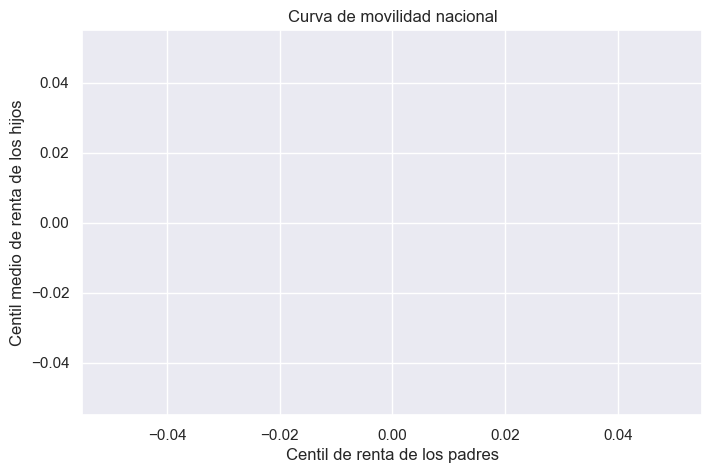

✅ Guardado CSV para gráfico: data/atlas_charts\curva_movilidad_nacional.csv


In [15]:
plt.figure(figsize=(8,5))
plt.plot(mov_nat_base[COL_P_PADRES], mov_nat_base[COL_P_HIJOS_M])
plt.xlabel("Centil de renta de los padres")
plt.ylabel("Centil medio de renta de los hijos")
plt.title("Curva de movilidad nacional")
plt.grid(True)
plt.show()

# Exportar datos del gráfico
export_chart_df(mov_nat_base, "curva_movilidad_nacional")

## 5. Ranking por CCAA (ejemplo con padres en centil 20)
Usamos `tabla_ccaa` para construir un ranking de CCAA para, por ejemplo, padres en centil 20.

👉 De nuevo, ajusta los nombres de columnas (`COL_CCAA_NOMBRE`, `COL_P_PADRES`, `COL_P_HIJOS_M`).

In [16]:
# AJUSTA ESTOS NOMBRES A TU CSV REAL
COL_CCAA_NOMBRE = "ccaa"  # p.ej.: 'ccaa', 'nombre_ccaa', etc.
# Reutilizamos COL_P_PADRES y COL_P_HIJOS_M definidos antes

P_PADRES_OBJETIVO = 20  # centil 20 = padres pobres

df_ccaa_p20 = tabla_ccaa[tabla_ccaa[COL_P_PADRES] == P_PADRES_OBJETIVO]

ranking_ccaa = (
    df_ccaa_p20.groupby(COL_CCAA_NOMBRE)[COL_P_HIJOS_M]
    .mean()
    .reset_index()
    .sort_values(COL_P_HIJOS_M, ascending=False)
)

ranking_ccaa.head(10)

,ccaa,centil_hijo_loess
8,CataluÃ±a,54.53
1,AragÃ³n,53.61
14,"Rioja, La",52.26
12,"Madrid, Comunidad de",51.53
3,"Balears, Illes",51.44
7,Castilla y LeÃ³n,48.56
6,Castilla - La Mancha,48.27
5,Cantabria,47.29
11,Galicia,45.66
2,"Asturias, Principado de",44.84


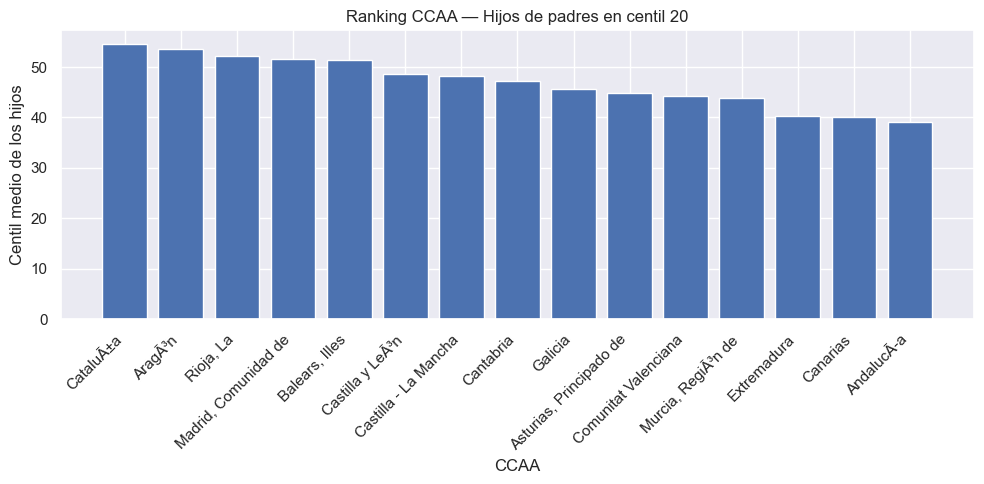

✅ Guardado CSV para gráfico: data/atlas_charts\ranking_ccaa_centil_padres_20.csv


In [17]:
plt.figure(figsize=(10,5))
plt.bar(ranking_ccaa[COL_CCAA_NOMBRE], ranking_ccaa[COL_P_HIJOS_M])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Centil medio de los hijos")
plt.xlabel("CCAA")
plt.title(f"Ranking CCAA — Hijos de padres en centil {P_PADRES_OBJETIVO}")
plt.tight_layout()
plt.show()

# Exportar datos del gráfico de ranking CCAA
export_chart_df(ranking_ccaa, f"ranking_ccaa_centil_padres_{P_PADRES_OBJETIVO}")

## 6. Quintiles nacionales — tabla pivot para barras apiladas
Usamos `tabla_quintiles_nac` para montar una tabla con:
- Índice: quintil de los padres.
- Columnas: quintil de los hijos.
- Valores: porcentaje.

👉 Ajusta nombres de columnas (`COL_Q_PADRES`, `COL_Q_HIJOS`, `COL_PERC`).

In [18]:
# AJUSTA ESTOS NOMBRES
COL_Q_PADRES = "quintil_padres"   # p.ej.: 'quintil_padres'
COL_Q_HIJOS  = "quintil_hijos"    # p.ej.: 'quintil_hijos'
COL_PERC     = "porcentaje"       # p.ej.: 'porcentaje'

tabla_quintiles = tabla_quintiles_nac.pivot_table(
    index=COL_Q_PADRES,
    columns=COL_Q_HIJOS,
    values=COL_PERC,
    aggfunc='mean'
)

tabla_quintiles

KeyError: 'porcentaje'

In [ ]:
tabla_quintiles.plot(kind="bar", stacked=True, figsize=(8,5))
plt.ylabel("Porcentaje de hijos")
plt.xlabel("Quintil de los padres")
plt.title("Distribución de quintiles de hijos según quintil de padres (nacional)")
plt.legend(title="Quintil hijos")
plt.tight_layout()
plt.show()

# Para exportar, mejor con índice como columna
tabla_quintiles_export = tabla_quintiles.reset_index()
export_chart_df(tabla_quintiles_export, "distribucion_quintiles_nacional_padres_hijos")

## 7. Conversor de centiles → euros (hijos)
Dataset útil para tooltips del dashboard: convertir centiles de renta a euros aproximados.

👉 Ajusta nombres (`COL_PERC`, `COL_EUROS`) según `conversor_percentil_euro.csv`.


In [ ]:
# AJUSTA ESTOS NOMBRES A TU CSV
COL_PERC = "percentil"          # ej.: 'percentil'
COL_EUROS = "euros"             # ej.: 'renta_bruta_euros', 'euros', etc.

tabla_conv_hijos = conversor_hijos[[COL_PERC, COL_EUROS]].dropna()

def centil_hijos_a_euros(c):
    fila = tabla_conv_hijos.loc[tabla_conv_hijos[COL_PERC] == c]
    if fila.empty:
        return np.nan
    return float(fila[COL_EUROS].iloc[0])

centil_hijos_a_euros(20), centil_hijos_a_euros(80)

In [ ]:
# Exportar conversor de centiles a euros (hijos)
export_chart_df(tabla_conv_hijos, "conversor_centiles_a_euros_hijos")
tabla_conv_hijos.head()

### (Opcional) Conversor de centiles → euros (padres)
Si quieres también convertir renta de padres a euros usando `conversor_percentil_euro_padres.csv`.

In [ ]:
# AJUSTA NOMBRES SI SON DISTINTOS EN EL CSV DE PADRES
COL_PERC_PADRES = "percentil"   # probablemente igual
COL_EUROS_PADRES = "euros"      # igual que en hijos, o similar

tabla_conv_padres = conversor_padres[[COL_PERC_PADRES, COL_EUROS_PADRES]].dropna()

def centil_padres_a_euros(c):
    fila = tabla_conv_padres.loc[tabla_conv_padres[COL_PERC_PADRES] == c]
    if fila.empty:
        return np.nan
    return float(fila[COL_EUROS_PADRES].iloc[0])

centil_padres_a_euros(20), centil_padres_a_euros(80)

# Export
export_chart_df(tabla_conv_padres, "conversor_centiles_a_euros_padres")
tabla_conv_padres.head()

## 8. Exportar tablas "curadas" para backend o análisis
Además de los CSV de gráficos, dejamos un pack de tablas base en `data/atlas_preparado`.

Puedes luego servir estos CSV desde Express o leerlos directamente desde el frontend (según cómo montes el proyecto).

In [ ]:
EXPORT_PREP_PATH = "data/atlas_preparado"
os.makedirs(EXPORT_PREP_PATH, exist_ok=True)

mov_nat_base.to_csv(os.path.join(EXPORT_PREP_PATH, "movilidad_nacional_curva.csv"), index=False)
ranking_ccaa.to_csv(os.path.join(EXPORT_PREP_PATH, f"ranking_ccaa_centil_padres_{P_PADRES_OBJETIVO}.csv"), index=False)
tabla_quintiles_export.to_csv(os.path.join(EXPORT_PREP_PATH, "distribucion_quintiles_nacional_pivot.csv"), index=False)
tabla_conv_hijos.to_csv(os.path.join(EXPORT_PREP_PATH, "conversor_centiles_euros_hijos_simple.csv"), index=False)
tabla_conv_padres.to_csv(os.path.join(EXPORT_PREP_PATH, "conversor_centiles_euros_padres_simple.csv"), index=False)

print("✅ CSV curados exportados en:", EXPORT_PREP_PATH)

## 9. Re-exportar todos los CSV de gráficos de una vez
Por si cambias filtros (sexo, tipo de renta, percentil de padres, etc.) y quieres regenerarlo todo de golpe.

In [ ]:
dfs_graficos = {
    "curva_movilidad_nacional": mov_nat_base,
    f"ranking_ccaa_centil_padres_{P_PADRES_OBJETIVO}": ranking_ccaa,
    "distribucion_quintiles_nacional_padres_hijos": tabla_quintiles_export,
    "conversor_centiles_a_euros_hijos": tabla_conv_hijos,
    "conversor_centiles_a_euros_padres": tabla_conv_padres
}

for name, df in dfs_graficos.items():
    export_chart_df(df, name)

print("✅ Re-exportados todos los CSV de gráficos en:", EXPORT_CHARTS_PATH)